In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from mytools import Video, get_cuts

2023-12-09 23:13:43.887940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load model

The string value `load_parameter` define the method to choose.

If `load_parameter == 'new'` then the model with the last filename from the directory __models__ will be load. _I use the date and time to construct model filename._

Else the model with the heighest value in `load_parameter`-column from __metrics.csv__ will be load. That table contains columns:
- `'model path'`
- `'Total Accuracy'`
- `'Total Precision'`
- `'Total Recall',`
- `'Train Accuracy'`
- `'Train Precision'`
- `'Train Recall'`
- `'Test Accuracy'`
- `'Test Precision'`
- `'Test Recall'`

In [2]:
load_parameter = 'Total Precision'

if load_parameter == 'new':
    model_path = 'models'
    model_files = np.array(os.listdir(model_path))
    model_files = np.sort(model_files[np.char.find(model_files, '.h5') != -1])
    model_path = os.path.join(model_path, model_files[-1])
else:
    df_metrics = pd.read_csv('metrics.csv')
    model_path = df_metrics[df_metrics[load_parameter] == df_metrics[load_parameter].max()]['model path'].values[0]
    
print(f'We a going to upload model {model_path}')

We a going to upload model models/2023-12-09-01-39.h5


In [3]:
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 4, 70, 126, 64)    5248      
                                                                 
 max_pooling3d (MaxPooling3  (None, 4, 35, 63, 64)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 32, 60, 64)     262208    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 16, 30, 64)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 192)               5

In [4]:
input_size = tuple(model.input.shape[1:])
video_size = input_size[1], input_size[2]
print(f'Model input shape is {input_size}')
print(f'So video size should be {video_size}')

Model input shape is (6, 72, 128, 3)
So video size should be (72, 128)


## Define model predicts path

In [5]:
path_predicts = 'predicts'
if not os.path.exists(path_predicts):
    os.mkdir(path_predicts)

In [6]:
model_name = model_path[model_path.find('/')+1:model_path.find('.')]
path_model_predicts = os.path.join(path_predicts, model_name)

if not os.path.exists(path_model_predicts):
    os.mkdir(path_model_predicts)

In [7]:
path_predict_template = os.path.join(path_model_predicts, '{0}.npy')
path_predict_template

'predicts/2023-12-09-01-39/{0}.npy'

# Analyzer

In [8]:
def predict_cuts(model, video: Video, fill=True, fill_value=0, fill_begin=None, fill_end=None):
    """
    Returns predicted cuts.
    
    Parameters:
    -----------
    model : keras model
    
    video : mytools.Video
    
    fill : bool
        Add values to the begin and end of result
    
    fill_value : int or bool
        Value, which will added to the begin and the end, if fill is True
        
    fill_begin : int
        Number of added values to begin
        
    fill_end : int
        Number of added values to end
    
    Returns:
    --------
    res : np.array
    """
    input_size = tuple(model.input.shape[1:])
    video_size = input_size[2], input_size[1]
    fragment_length = input_size[0]
    if (fill_begin is None) and (fill_end is None):
        fill_begin = fragment_length // 2
        fill_end = fragment_length - fill_begin
    elif fill_end is None:
        fill_end = fragment_length - fill_begin
    elif fill_begin is None:
        fill_begin = fragment_length - fill_end
    
    res = []
    
    pbar = tqdm(total=len(video) - fragment_length)
    # Make here loop of video fragments length 4 (fragment_length) and add predicted value every step
    for matrix in video.generate_matrices(matrix_length=fragment_length, new_size=video_size):
        X = matrix.reshape(np.append(1, matrix.shape))
        y = model(X)
        res.append(y)
        pbar.update()
    pbar.close()
    
    if fill:
        res = np.concatenate([np.ones(fill_begin)*fill_value, np.array(res)[:, 0, 0], np.ones(fill_end)*fill_value])
    return res

# Analyzing videos

## Video 0

In [9]:
video_index = 0
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 25.0000


In [10]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([ 107,  206,  221,  226,  237,  244,  249,  253,  256,  265,  273,
        295,  325,  329,  333,  338,  341,  365,  378,  384,  394,  404,
        419,  423,  432,  500,  580,  640,  665,  686,  711,  724,  762,
        775,  791,  806,  819,  841,  908,  958, 1083, 1151, 1186, 1233,
       1250, 1299, 1343, 1375, 1389, 1403, 1419, 1440, 1483, 1533, 1572,
       1596, 1634, 1657, 1750, 1918, 2005, 2100, 2190, 2249, 2303, 2329,
       2353, 2385, 2407, 2444, 2486, 2521, 2565, 2587, 2621, 2694, 2727,
       2748, 2763, 2792, 2816, 2828, 2846, 2862, 2878, 2889, 2901, 2921,
       2935, 2947, 2969, 2986, 2998, 3014, 3031, 3045, 3060, 3068, 3108,
       3185, 3239, 3284, 3324, 3368, 3415, 3451, 3503, 3615, 3679, 3712,
       3870, 3905, 3936, 3960, 3982, 4006, 4027, 4210, 4246, 4275, 4298,
       4326, 4363, 4400, 4433, 4472, 4511, 4592, 4608, 4648, 4674, 4700,
       4726, 4754, 4775, 4812, 4845, 4877, 4924, 4951, 4985, 5016, 5065,
       5129, 5156, 5216, 5253, 5310, 5367, 5502, 58

In [11]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [12]:
path_predict = path_predict_template.format(video_index)
try:
    cuts_predicted = np.load(path_predict)
except FileNotFoundError:
    cuts_predicted = predict_cuts(model, video)
    np.save(path_predict, cuts_predicted)

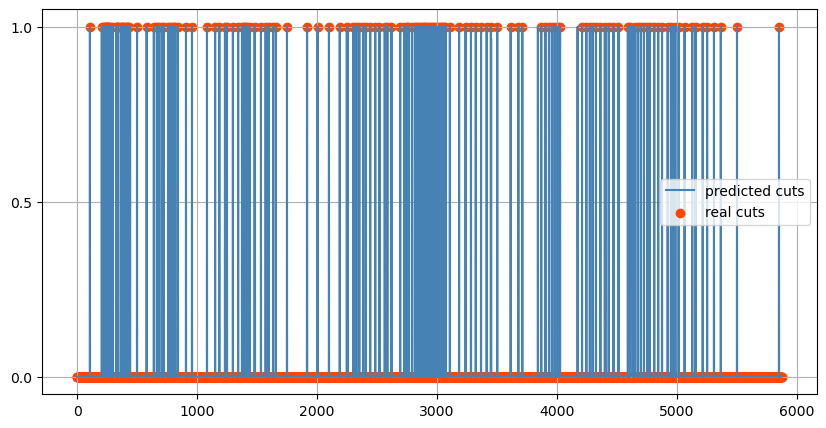

In [13]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [14]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[232:].head(20).transpose()

232    233    234    235    236   237    238    239    240  \
real cut       False  False  False  False  False  True  False  False  False   
predicted cut  False  False  False  False  False  True  False  False  False   

                 241    242    243   244    245    246    247    248   249  \
real cut       False  False  False  True  False  False  False  False  True   
predicted cut  False  False  False  True  False  False  False  False  True   

                 250    251  
real cut       False  False  
predicted cut  False  False

In [15]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              5666             58
real cut                    2            149

In [16]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.99% wrong cuts predicted and 0.03% wrong noncuts.
But the real cuts portion is just 2.54%


predicted noncut  predicted cut
real noncut          0.964426       0.009872
real cut             0.000340       0.025362

/tmp/ipykernel_42746/1528520417.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


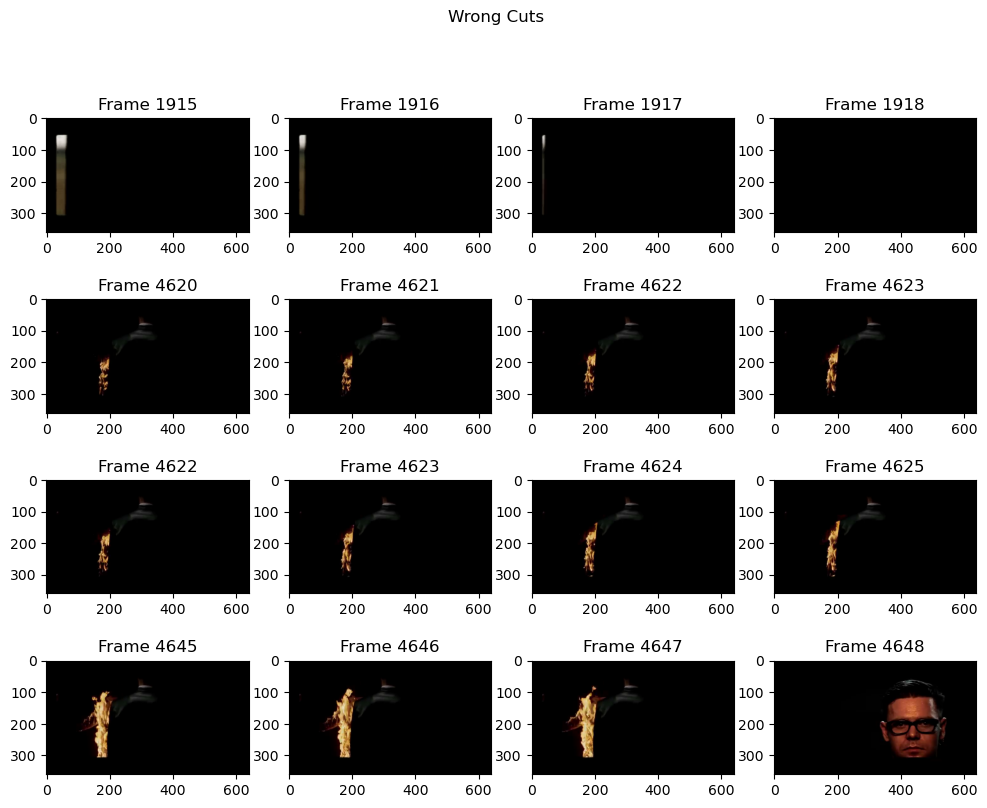

In [17]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))


fig, axs = plt.subplots(4, 4)

fig.set_figheight(9)
fig.set_figwidth(12)
fig.suptitle('Wrong Cuts')

for i in range(4):
    for k in range(4):
        idx = chosen_wrong_cuts[i] - 2 + k
        frame = video.get_frame(idx)
        axs[i, k].set_title(f'Frame {idx}')
        axs[i, k].imshow(frame)
fig.show()

In [18]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        fig.show()
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

/tmp/ipykernel_42746/2433818751.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [19]:
dfs_frames = []
dfs_square = []

In [20]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

## Video 1

In [21]:
video_index = 1
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 23.9760


In [22]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([ 101,  140,  184,  202,  239,  290,  385,  402,  426,  447,  502,
        546,  607,  624,  637,  650,  670,  688,  703,  713,  738,  755,
        776,  789,  810,  851,  878,  921,  942,  960,  982,  998, 1009,
       1053, 1074, 1077, 1079, 1084, 1106, 1123, 1149, 1174, 1193, 1196,
       1199, 1201, 1208, 1213, 1250, 1253, 1259, 1276, 1293, 1295, 1302,
       1306, 1312, 1352, 1415, 1446, 1466, 1503, 1522, 1561, 1593, 1604,
       1617, 1686, 1741, 1765, 1801, 1810, 1820, 1845, 1877, 1905, 1927,
       1970, 2021, 2066, 2109, 2123, 2134, 2158, 2195, 2204, 2210, 2224,
       2248, 2273, 2295, 2316, 2329, 2349, 2374, 2384, 2400, 2407, 2412,
       2425, 2443, 2454, 2466, 2472, 2478, 2510, 2557, 2561, 2568, 2573,
       2577, 2601, 2613, 2623, 2717, 2772, 2795, 2829, 2847, 2857, 2871,
       2875, 2878, 2882, 2908, 2915, 2933, 2950, 2958, 2969, 2983, 2992,
       2998, 3006, 3013, 3015, 3016, 3017, 3018, 3019, 3021, 3022, 3027,
       3032, 3119, 3134, 3183, 3233, 3268, 3323, 33

In [23]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [24]:
path_predict = path_predict_template.format(video_index)
try:
    cuts_predicted = np.load(path_predict)
except FileNotFoundError:
    cuts_predicted = predict_cuts(model, video)
    np.save(path_predict, cuts_predicted)

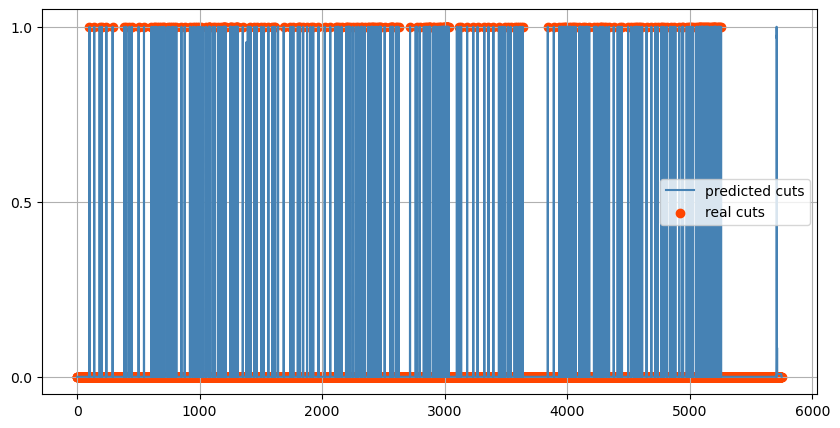

In [25]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [26]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[321:].head(20).transpose()

321    322    323    324    325    326    327    328    329  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 330    331    332    333    334    335    336    337    338  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 339    340  
real cut       False  False  
predicted cut  False  False

In [27]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              5378            132
real cut                    2            238

In [28]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 2.30% wrong cuts predicted and 0.03% wrong noncuts.
But the real cuts portion is just 4.14%


predicted noncut  predicted cut
real noncut          0.935304       0.022957
real cut             0.000348       0.041391

/tmp/ipykernel_42746/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


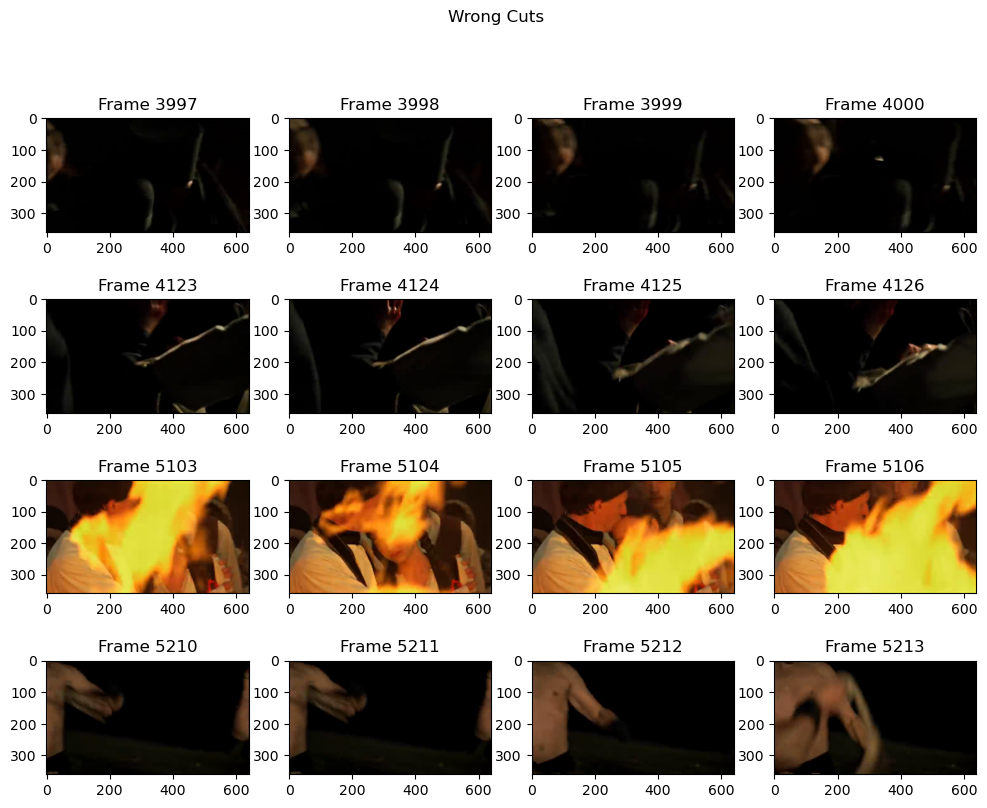

In [29]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

/tmp/ipykernel_42746/519586235.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


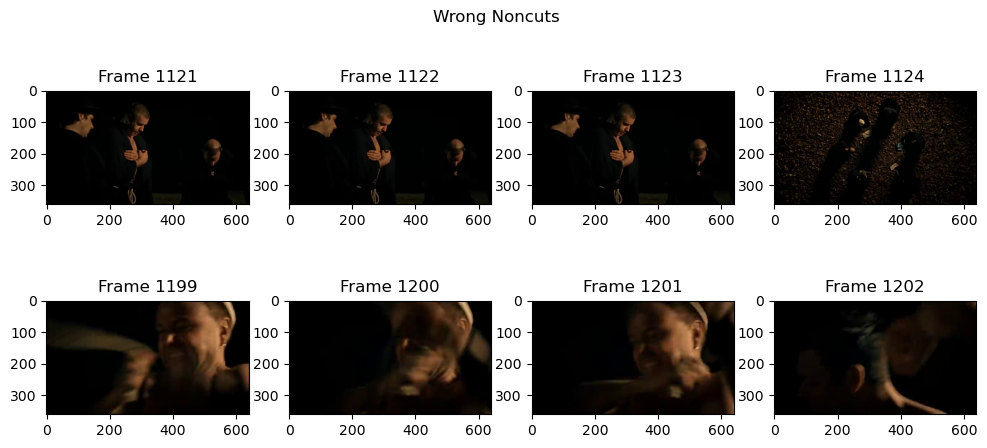

In [30]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

Wrong labaling: 941, 1192.

Changing FPS value in get_cuts have not resolved that.

In [31]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

## Video 2

In [32]:
video_index = 2
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 23.9760


In [33]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([  23,   65,   95,  103,  131,  141,  170,  180,  191,  208,  220,
        256,  282,  297,  315,  332,  348,  373,  404,  426,  470,  484,
        493,  512,  531,  548,  561,  586,  608,  666,  684,  710,  786,
        800,  814,  845,  864,  890,  925,  961,  992, 1007, 1076, 1098,
       1118, 1146, 1163, 1192, 1242, 1293, 1327, 1369, 1387, 1404, 1428,
       1456, 1484, 1497, 1519, 1546, 1570, 1601, 1625, 1635, 1640, 1646,
       1684, 1698, 1761, 1799, 1822, 1852, 1893, 1905, 1928, 1943, 1960,
       1992, 2012, 2049, 2084, 2102, 2332, 2393, 2409, 2558, 2581, 2597,
       2623, 2679, 2759, 2848, 2910, 2959, 3044, 3121, 3139, 3173, 3204,
       3238, 3264, 3295, 3353, 3405, 3457, 3483, 3522, 3596, 3609, 3622,
       3658, 3697, 3745, 3813, 3917, 4015, 4061, 4152, 4221, 4313, 4426,
       4468, 4522, 4590, 4698, 4731, 4797, 4839, 4869, 4933, 4989, 5020,
       5058, 5107, 5146, 5174, 5204, 5228, 5306, 5350, 5457, 5530, 5573,
       5608, 5620, 5643, 5660, 5676, 5704, 5735])

In [34]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [35]:
path_predict = path_predict_template.format(video_index)
try:
    cuts_predicted = np.load(path_predict)
except FileNotFoundError:
    cuts_predicted = predict_cuts(model, video)
    np.save(path_predict, cuts_predicted)

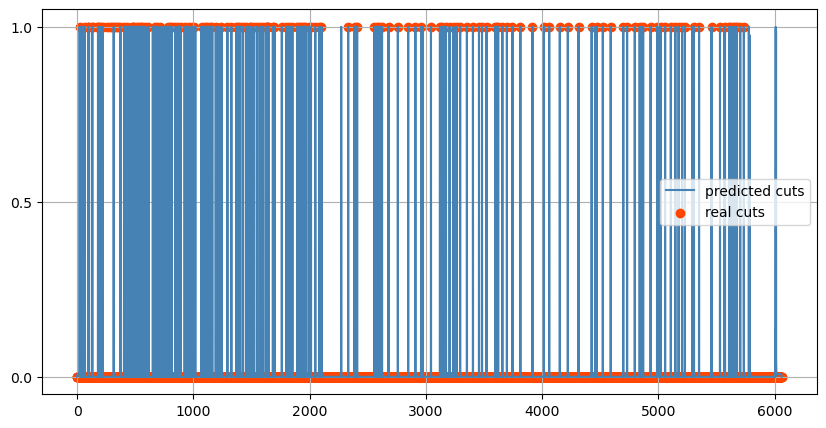

In [36]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [37]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[321:].head(20).transpose()

321    322    323    324    325    326    327    328    329  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 330    331    332    333    334    335    336    337    338  \
real cut       False  False   True  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 339    340  
real cut       False  False  
predicted cut  False  False

In [38]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              5795            116
real cut                   11            139

In [39]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 1.91% wrong cuts predicted and 0.18% wrong noncuts.
But the real cuts portion is just 2.29%


predicted noncut  predicted cut
real noncut          0.956113       0.019139
real cut             0.001815       0.022934

In [40]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

/tmp/ipykernel_42746/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


/tmp/ipykernel_42746/519586235.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


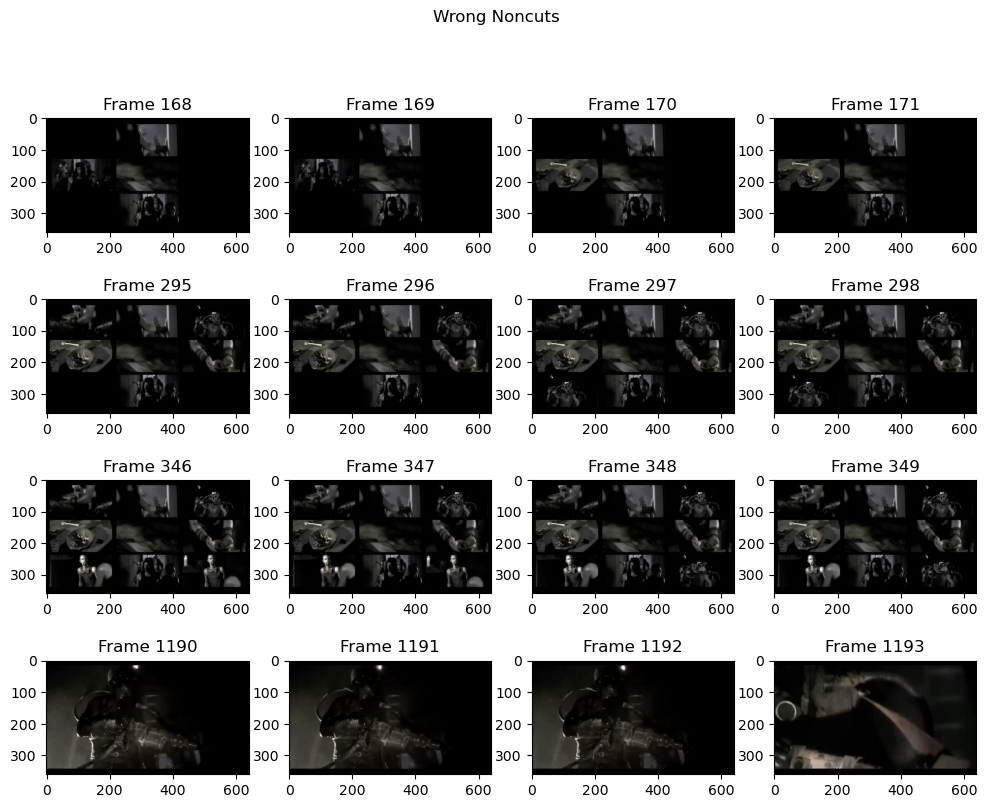

In [41]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

Many cuts on 9 little frames are realy specific.

In [42]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

## Video 3

In [43]:
video_index = 3
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 25.0000


In [44]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([ 160,  203,  320,  479,  639,  757,  970, 1049, 1119, 1300, 1599,
       1760, 1919, 1999, 2245, 2344, 2401, 2560, 2719, 2880, 3040, 3359])

In [45]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [46]:
path_predict = path_predict_template.format(video_index)
try:
    cuts_predicted = np.load(path_predict)
except FileNotFoundError:
    cuts_predicted = predict_cuts(model, video)
    np.save(path_predict, cuts_predicted)

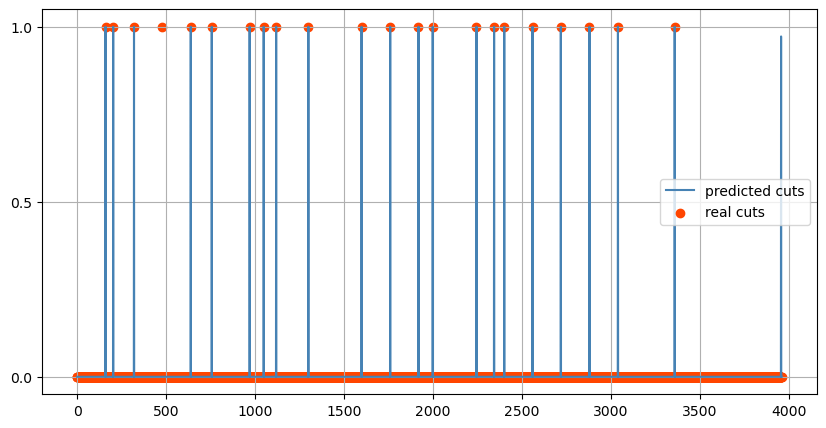

In [47]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [48]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[456:].head(20).transpose()

456    457    458    459    460    461    462    463    464  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 465    466    467    468    469    470    471    472    473  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 474    475  
real cut       False  False  
predicted cut  False  False

In [49]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              3938              1
real cut                    1             21

In [50]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.03% wrong cuts predicted and 0.03% wrong noncuts.
But the real cuts portion is just 0.53%


predicted noncut  predicted cut
real noncut          0.994193       0.000252
real cut             0.000252       0.005302

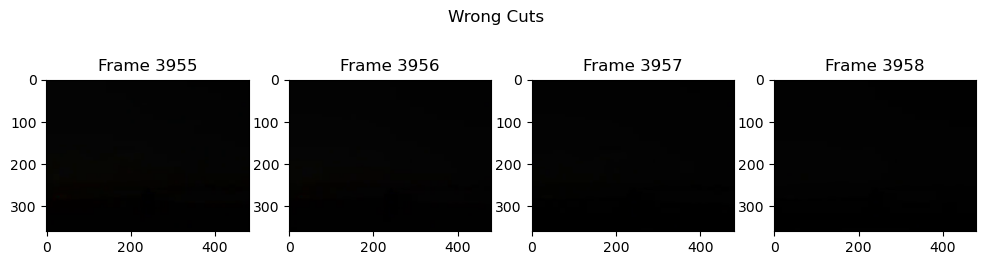

In [51]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

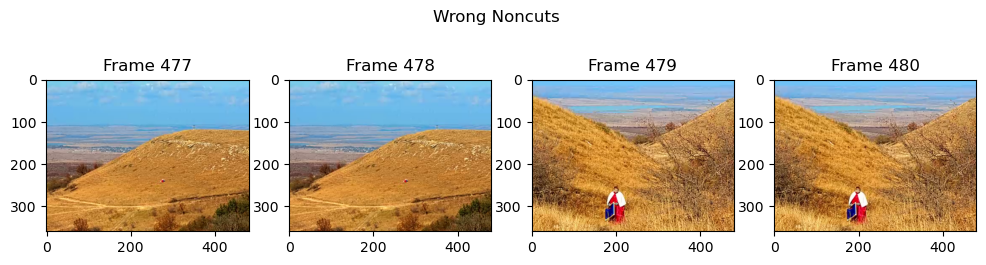

In [52]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

In [53]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

## Video 4

In [54]:
video_index = 4
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 23.9760


In [55]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([  25,  162,  232,  260,  284,  312,  336,  366,  389,  415,  439,
        471,  492,  520,  539,  566,  610,  656,  693,  745,  770,  792,
        819,  837,  860,  881,  910,  938,  974,  995, 1020, 1043, 1065,
       1073, 1101, 1123, 1145, 1167, 1177, 1206, 1227, 1247, 1266, 1284,
       1307, 1323, 1344, 1360, 1379, 1405, 1420, 1439, 1460, 1489, 1517,
       1546, 1562, 1592, 1609, 1641, 1671, 1698, 1735, 1759, 1788, 1805,
       1830, 1853, 1866, 1879, 1889, 1901, 1918, 1932, 1960, 1972, 1990,
       2003, 2030, 2042, 2055, 2064, 2071, 2080, 2092, 2102, 2114, 2142,
       2169, 2193, 2204, 2222, 2243, 2255, 2274, 2280, 2295, 2321, 2351,
       2369, 2381, 2396, 2420, 2437, 2455, 2469, 2478, 2510, 2536, 2563,
       2583, 2604, 2624, 2647, 2664, 2680, 2689, 2706, 2721, 2734, 2741,
       2758, 2771, 2810, 2843, 2872, 3013, 3160, 3196, 3221, 3249, 3282,
       3319, 3345, 3371, 3393, 3426, 3473, 3502, 3553, 3580, 3650, 3689,
       3729, 3758, 3796, 3810, 3848, 3863, 3900, 39

In [56]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [57]:
path_predict = path_predict_template.format(video_index)
try:
    cuts_predicted = np.load(path_predict)
except FileNotFoundError:
    cuts_predicted = predict_cuts(model, video)
    np.save(path_predict, cuts_predicted)

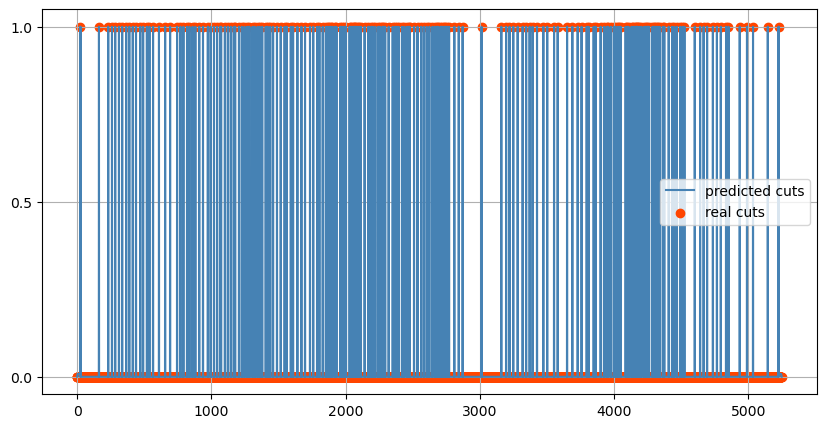

In [58]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [59]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[456:].head(20).transpose()

456    457    458    459    460    461    462    463    464  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 465    466    467    468    469    470   471    472    473  \
real cut       False  False  False  False  False  False  True  False  False   
predicted cut  False  False  False  False  False  False  True  False  False   

                 474    475  
real cut       False  False  
predicted cut  False  False

In [60]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              5033             13
real cut                    1            202

In [61]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.25% wrong cuts predicted and 0.02% wrong noncuts.
But the real cuts portion is just 3.85%


predicted noncut  predicted cut
real noncut          0.958849       0.002477
real cut             0.000191       0.038484

/tmp/ipykernel_42746/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


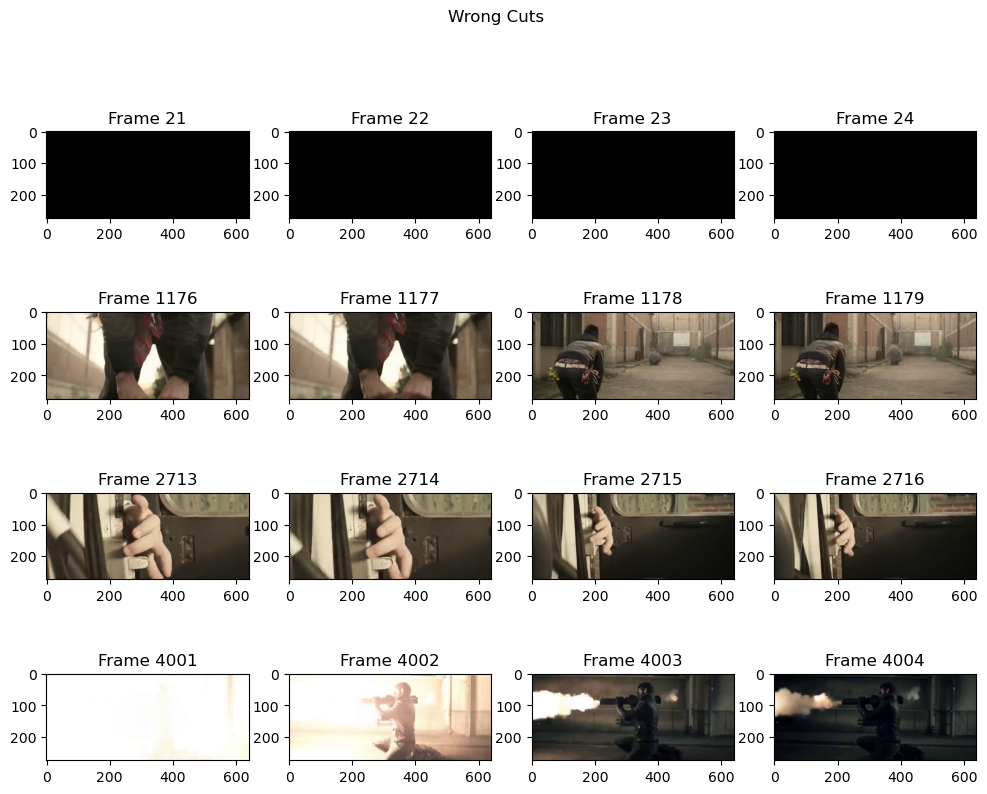

In [62]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

There are many stable segments! Why?

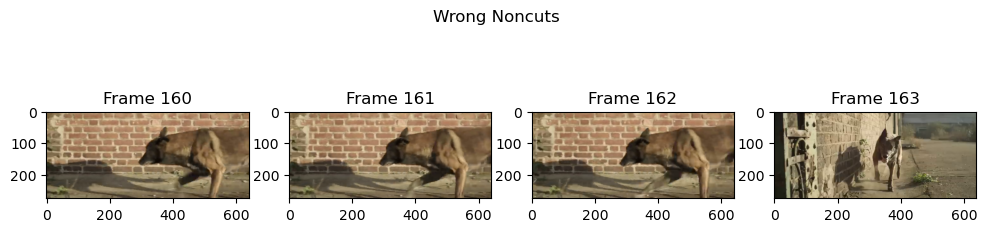

In [63]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

In [64]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

## Video 5

In [65]:
video_index = 5
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 25.0000


In [66]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([  46,   99,  145,  177,  269,  303,  347,  381,  427,  464,  488,
        531,  561,  609,  640,  664,  687,  715,  759,  790,  837,  914,
        988, 1061, 1098, 1142, 1175, 1367, 1493, 1516, 1670, 1747, 1800,
       1826, 1895, 1973, 2045, 2095, 2130, 2205, 2244, 2282, 2354, 2392,
       2436, 2634, 2658, 2708, 2733, 2812, 2880, 2963, 3065, 3112, 3186,
       3265, 3342, 3493, 3521, 3571, 3617, 3646, 3668, 3689, 3718, 3760,
       3800, 3838, 3873, 3898, 3925, 3952, 3995, 4025, 4076, 4103, 4130,
       4160, 4198, 4225, 4253, 4329, 4387, 4480, 4521, 4554, 4610, 4658,
       4700, 4749, 4787, 4856, 4972])

In [67]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [68]:
path_predict = path_predict_template.format(video_index)
try:
    cuts_predicted = np.load(path_predict)
except FileNotFoundError:
    cuts_predicted = predict_cuts(model, video)
    np.save(path_predict, cuts_predicted)

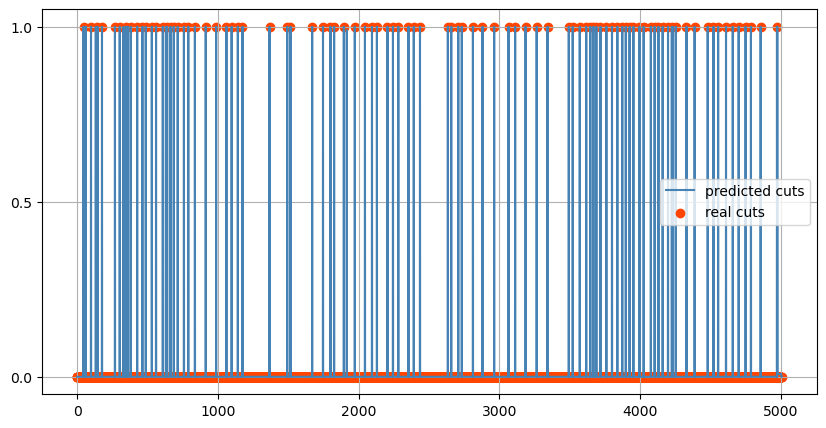

In [69]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [70]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[456:].head(20).transpose()

456    457    458    459    460    461    462    463   464  \
real cut       False  False  False  False  False  False  False  False  True   
predicted cut  False  False  False  False  False  False  False  False  True   

                 465    466    467    468    469    470    471    472    473  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 474    475  
real cut       False  False  
predicted cut  False  False

In [71]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              4905              8
real cut                    0             93

In [72]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.16% wrong cuts predicted and 0.00% wrong noncuts.
But the real cuts portion is just 1.86%


predicted noncut  predicted cut
real noncut          0.979824       0.001598
real cut             0.000000       0.018578

In [73]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

/tmp/ipykernel_42746/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [74]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

The number of wrong cuts is 0, so there is nothing to draw.


In [75]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

##  Video 6

In [76]:
video_index = 6
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 25.0000


In [77]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([  19,  186,  271,  369,  515,  569,  656,  699,  758,  852,  877,
        973, 1006, 1079, 1151, 1208, 1301, 1382, 1485, 1527, 1605, 1686,
       1770, 1818, 1854, 1888, 2052, 2103, 2197, 2279, 2317, 2432, 2487,
       2658, 2685, 2781, 2840, 2898, 2952, 3007, 3150, 3223, 3286, 3338,
       3410, 3442, 3550, 3593, 3702, 3797, 3863, 3923, 4007, 4032, 4108,
       4198, 4249, 4303, 4348, 4455, 4500, 4685, 4692, 4768, 4812, 4867,
       4882, 4948, 4979, 5097])

In [78]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [79]:
path_predict = path_predict_template.format(video_index)
try:
    cuts_predicted = np.load(path_predict)
except FileNotFoundError:
    cuts_predicted = predict_cuts(model, video)
    np.save(path_predict, cuts_predicted)

In [80]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [81]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[456:].head(20).transpose()

456    457    458    459    460    461    462    463    464  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 465    466    467    468    469    470    471    472    473  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 474    475  
real cut       False  False  
predicted cut  False  False

In [82]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              5114             22
real cut                    0             70

In [83]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.42% wrong cuts predicted and 0.00% wrong noncuts.
But the real cuts portion is just 1.34%


predicted noncut  predicted cut
real noncut          0.982328       0.004226
real cut             0.000000       0.013446

In [84]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

/tmp/ipykernel_42746/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [85]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

The number of wrong cuts is 0, so there is nothing to draw.


In [86]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

## Video 7

In [87]:
video_index = 7
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 23.9760


In [88]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([   7,  153,  227,  299,  403,  541,  694,  802,  897,  987, 1013,
       1033, 1125, 1183, 1291, 1338, 1428, 1487, 1526, 1588, 1630, 1732,
       1783, 1923, 2026, 2082, 2138, 2285, 2370, 2413, 2509, 2562, 2614,
       2636, 2663, 2745, 2807, 2875, 2918, 2958, 3068, 3219, 3255, 3331,
       3400, 3494, 3548, 3585, 3623, 3657, 3694, 3800, 3878, 3934, 3992,
       4072, 4124, 4211, 4244, 4286, 4332, 4369, 4435, 4584, 4688, 4729,
       4823, 4875, 4937, 4983, 5043, 5089, 5173, 5224, 5275, 5321, 5469,
       5620, 5766, 5909, 5923])

In [89]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [90]:
path_predict = path_predict_template.format(video_index)
try:
    cuts_predicted = np.load(path_predict)
except FileNotFoundError:
    cuts_predicted = predict_cuts(model, video)
    np.save(path_predict, cuts_predicted)

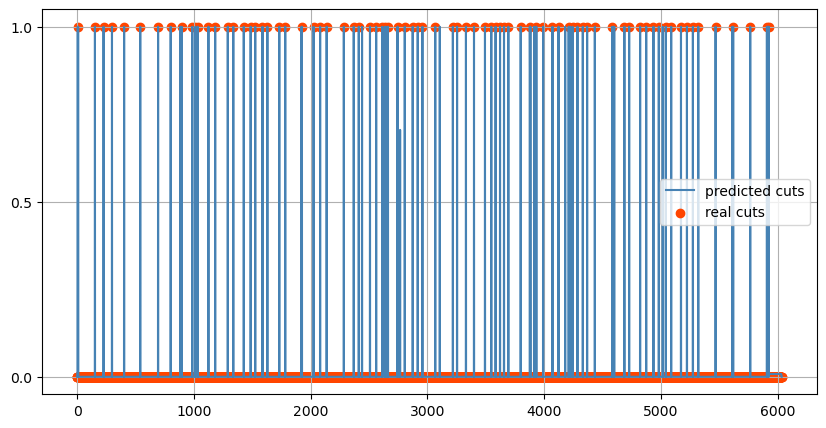

In [91]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [92]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[456:].head(20).transpose()

456    457    458    459    460    461    462    463    464  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 465    466    467    468    469    470    471    472    473  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 474    475  
real cut       False  False  
predicted cut  False  False

In [93]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              5932             23
real cut                    0             81

In [94]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.38% wrong cuts predicted and 0.00% wrong noncuts.
But the real cuts portion is just 1.34%


predicted noncut  predicted cut
real noncut           0.98277       0.003810
real cut              0.00000       0.013419

In [95]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

/tmp/ipykernel_42746/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [96]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

The number of wrong cuts is 0, so there is nothing to draw.


There are many flashs in Grimes's clip. So the model predict cuts and noncuts not well on that.

In [97]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

## Video 8

In [98]:
video_index = 8
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 25.0000


In [99]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([  25,  309, 1123, 1255, 1330, 1384, 1502, 1552, 1592, 1639, 1670,
       1718, 1844, 1889, 1932, 1997, 2093, 2166, 2229, 2278, 2341, 2431,
       2487, 2504, 2538, 2577, 2629, 2652, 2722, 2784, 2892, 3029, 3191,
       3260, 3330, 3396, 3453, 3510, 3564, 3655, 3744, 3869, 4028, 4093,
       4130, 4182, 4236, 4300, 4357, 4473, 4592, 4684, 4732, 4779, 4859,
       4933, 4999, 5185, 5488, 5588, 5749, 5838, 5891, 5981, 6050, 6208,
       6309, 6868, 7109])

In [100]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [101]:
path_predict = path_predict_template.format(video_index)
try:
    cuts_predicted = np.load(path_predict)
except FileNotFoundError:
    cuts_predicted = predict_cuts(model, video)
    np.save(path_predict, cuts_predicted)

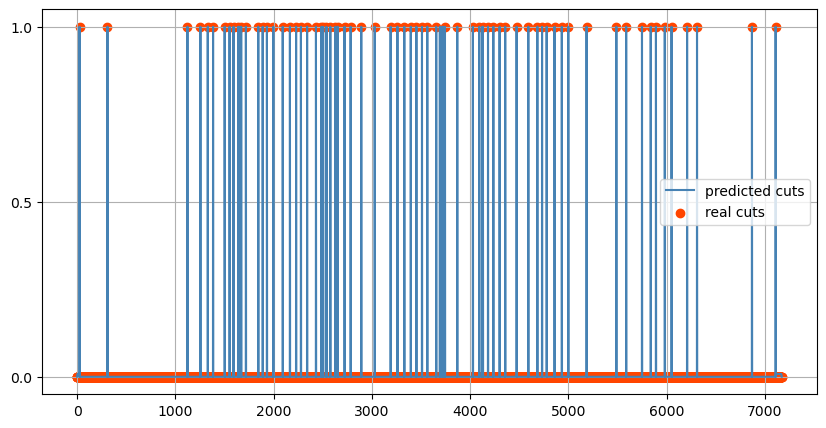

In [102]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [103]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[456:].head(20).transpose()

456    457    458    459    460    461    462    463    464  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 465    466    467    468    469    470    471    472    473  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 474    475  
real cut       False  False  
predicted cut  False  False

In [104]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              7094              8
real cut                    0             69

In [105]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.11% wrong cuts predicted and 0.00% wrong noncuts.
But the real cuts portion is just 0.96%


predicted noncut  predicted cut
real noncut          0.989262       0.001116
real cut             0.000000       0.009622

/tmp/ipykernel_42746/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


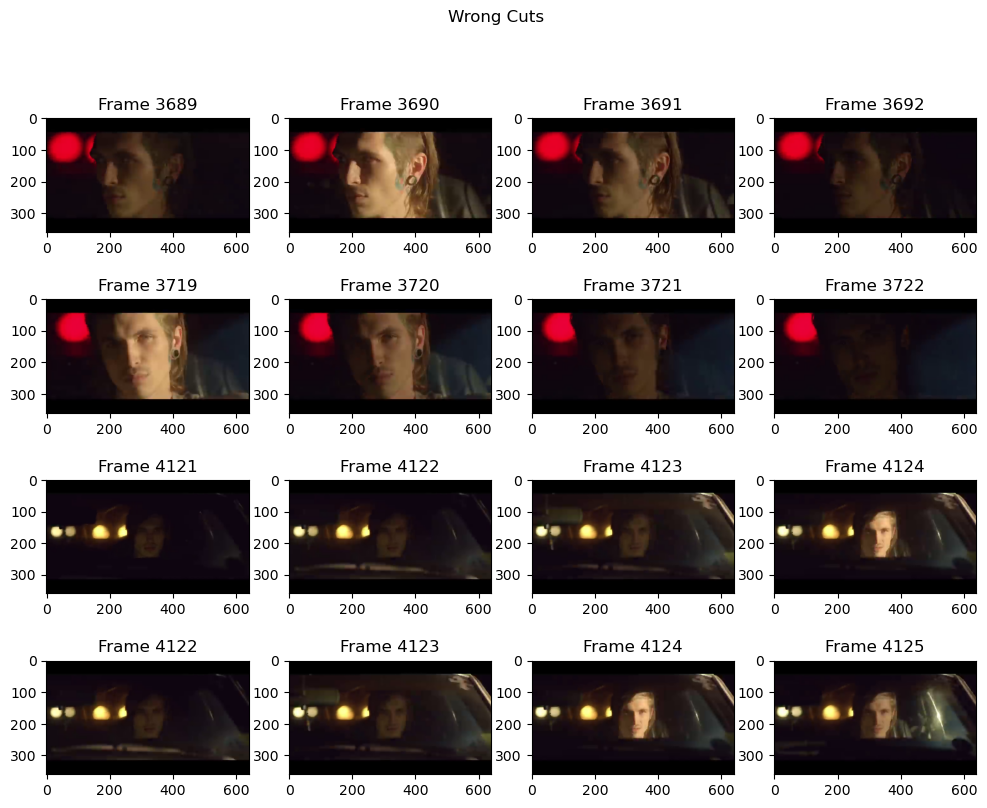

In [106]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

In [107]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

The number of wrong cuts is 0, so there is nothing to draw.


In [108]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

## Video 9

In [109]:
video_index = 9
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 23.9760


In [110]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([ 100,  162,  226,  243,  253,  310,  383,  399,  410,  481,  524,
        551,  573,  610,  688,  763,  819,  906,  946, 1137, 1166, 1318,
       1346, 1363, 1399, 1430, 1467, 1518, 1572, 1599, 1618, 1639, 1663,
       1681, 1711, 1813, 1830, 1851, 1874, 1915, 1929, 1946, 1960, 2010,
       2016, 2056, 2061, 2087, 2108, 2123, 2225, 2258, 2285, 2323, 2341,
       2367, 2417, 2449, 2502, 2528, 2624, 2712, 2780, 2825, 2872, 2968,
       3031, 3084, 3168, 3215, 3278, 3305, 3335, 3379, 3397, 3467, 3518,
       3639, 3713, 3834, 3875, 3906, 3946, 3990, 4031, 4058, 4089, 4127,
       4160, 4202, 4232, 4259, 4291, 4320, 4373, 4445, 4498, 4528, 4561,
       4592, 4627, 4659, 4717, 4734, 4743, 4766, 4792, 4847, 4873, 4966,
       5010, 5034, 5076, 5099, 5201, 5245, 5337, 5347, 5357, 5370, 5384,
       5420, 5484, 5512, 5545, 5592, 5686, 5718, 5733, 5747, 5764, 5779,
       5803, 5828, 5841, 5873, 5888, 5910, 5955, 5978, 6014, 6031, 6068,
       6092, 6110, 6134, 6157, 6180, 6260, 6588])

In [111]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [112]:
path_predict = path_predict_template.format(video_index)
try:
    cuts_predicted = np.load(path_predict)
except FileNotFoundError:
    cuts_predicted = predict_cuts(model, video)
    np.save(path_predict, cuts_predicted)

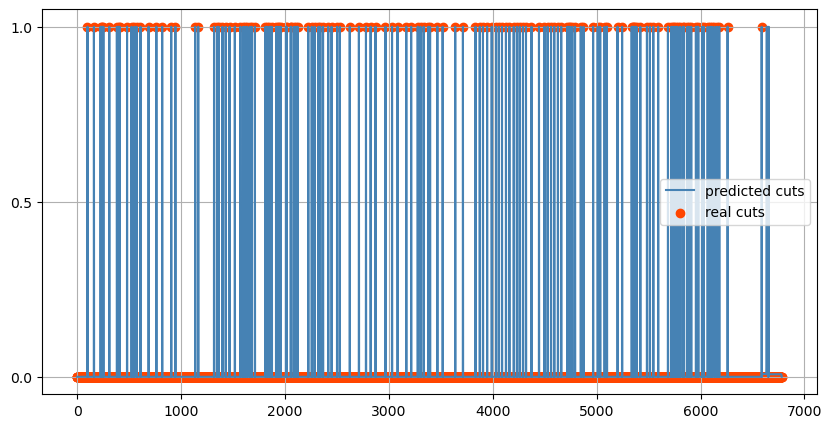

In [113]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [114]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[654:].head(20).transpose()

654    655    656    657    658    659    660    661    662  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 663    664    665    666    667    668    669    670    671  \
real cut       False  False  False  False  False  False  False  False  False   
predicted cut  False  False  False  False  False  False  False  False  False   

                 672    673  
real cut       False  False  
predicted cut  False  False

In [115]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              6612             19
real cut                    0            150

In [116]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 0.28% wrong cuts predicted and 0.00% wrong noncuts.
But the real cuts portion is just 2.21%


predicted noncut  predicted cut
real noncut          0.975077       0.002802
real cut             0.000000       0.022121

/tmp/ipykernel_42746/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


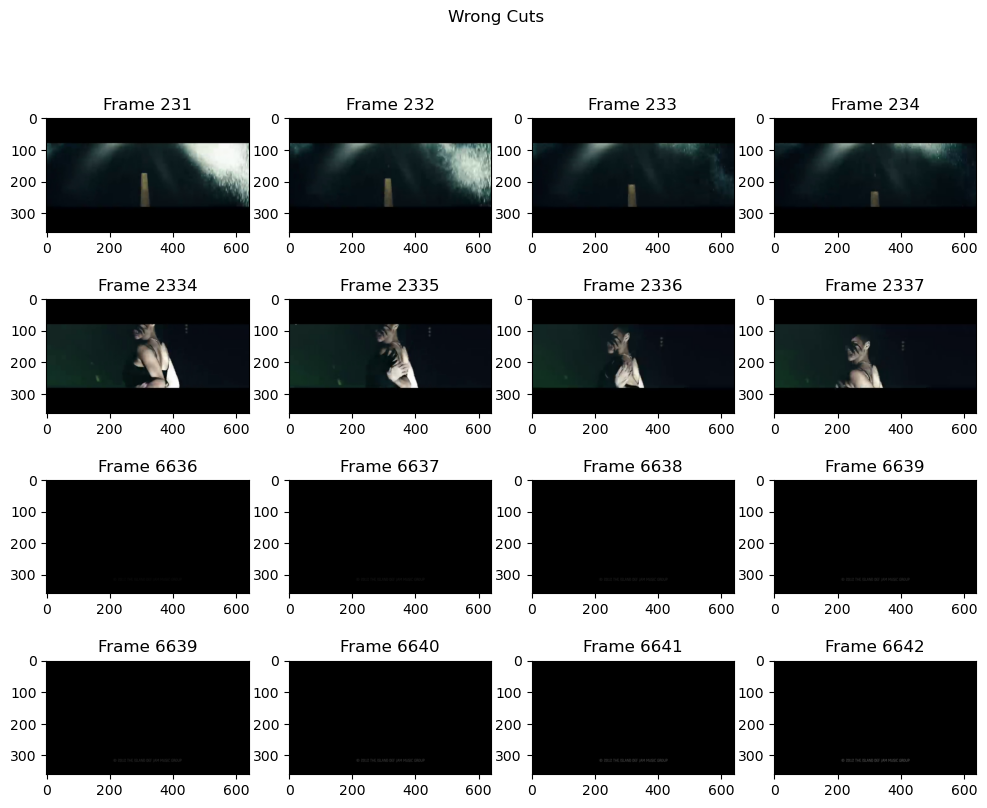

In [117]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

In [118]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

The number of wrong cuts is 0, so there is nothing to draw.


In [119]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

## Video 10

In [120]:
video_index = 10
video = Video(f'videos/{video_index}.mp4')
fps = video.get_fps()
print('FPS: {0:.4f}'.format(fps))
cuts = get_cuts(f'timelines/{video_index}.kdenlive', fps=fps)

FPS: 23.9760


In [121]:
cuts = np.load(f'cuts/{video_index}.npy').astype(int)
cuts

array([  12,   85,   94,  103,  112,  121,  130,  140,  149,  158,  167,
        176,  185,  194,  203,  212,  222,  231,  240,  248,  260,  267,
        276,  286,  294,  303,  313,  322,  331,  340,  349,  358,  367,
        375,  386,  395,  404,  413,  422,  430,  440,  448,  458,  467,
        476,  486,  495,  504,  513,  522,  531,  540,  549,  558,  568,
        577,  586,  595,  604,  613,  622,  631,  640,  650,  659,  668,
        677,  686,  695,  704,  713,  722,  731,  740,  750,  759,  768,
        777,  786,  795,  804,  813,  823,  832,  841,  851,  859,  868,
        877,  886,  895,  903,  913,  923,  932,  941,  950,  959,  968,
        977,  986,  995, 1005, 1014, 1023, 1032, 1041, 1050, 1059, 1068,
       1077, 1087, 1096, 1105, 1114, 1124, 1136, 1141, 1150, 1159, 1167,
       1178, 1187, 1196, 1206, 1214, 1223, 1232, 1242, 1250, 1259, 1269,
       1277, 1287, 1296, 1305, 1314, 1323, 1332, 1341, 1349, 1360, 1369,
       1378, 1387, 1396, 1405, 1414, 1424, 1432, 14

In [122]:
cuts_real = np.zeros(len(video))
cuts_real[cuts] = 1

In [123]:
path_predict = path_predict_template.format(video_index)
try:
    cuts_predicted = np.load(path_predict)
except FileNotFoundError:
    cuts_predicted = predict_cuts(model, video)
    np.save(path_predict, cuts_predicted)

In [124]:
n = len(video)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(n), cuts_predicted[:n], color='steelblue', label='predicted cuts')
plt.scatter(np.arange(n), cuts_real[:n], color='orangered', label='real cuts')
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.legend()
plt.show()

In [125]:
df_frame_info = pd.DataFrame({'real cut' : cuts_real == 1, 
                              'predicted cut' : cuts_predicted > 0.5})
df_frame_info[654:].head(20).transpose()

654    655    656    657    658   659    660    661    662  \
real cut       False  False  False  False  False  True  False  False  False   
predicted cut  False  False  False  False  False  True  False  False  False   

                 663    664    665    666    667   668    669    670    671  \
real cut       False  False  False  False  False  True  False  False  False   
predicted cut  False  False  False  False  False  True  False  False  False   

                 672    673  
real cut       False  False  
predicted cut  False  False

In [126]:
df_square = {'predicted noncut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == False)&(df_frame_info['real cut'] == True)])}, 
             'predicted cut' : {'real noncut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == False)]), 
                                   'real cut' : len(df_frame_info[(df_frame_info['predicted cut'] == True)&(df_frame_info['real cut'] == True)])}}
df_square = pd.DataFrame(df_square)
df_square

predicted noncut  predicted cut
real noncut              5036             61
real cut                    8            295

In [127]:
df_square_portion = df_square / df_square.values.sum()
print('There are {0:.2f}% wrong cuts predicted and {1:.2f}% wrong noncuts.'.format(100*float(df_square_portion.loc['real noncut', 'predicted cut']), 
                                                                                  100*float(df_square_portion.loc['real cut', 'predicted noncut'])))
print('But the real cuts portion is just {0:.2f}%'.format(100*float(df_square_portion.loc['real cut', 'predicted cut'])))
df_square_portion

There are 1.13% wrong cuts predicted and 0.15% wrong noncuts.
But the real cuts portion is just 5.46%


predicted noncut  predicted cut
real noncut          0.932593       0.011296
real cut             0.001481       0.054630

/tmp/ipykernel_42746/2537299419.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


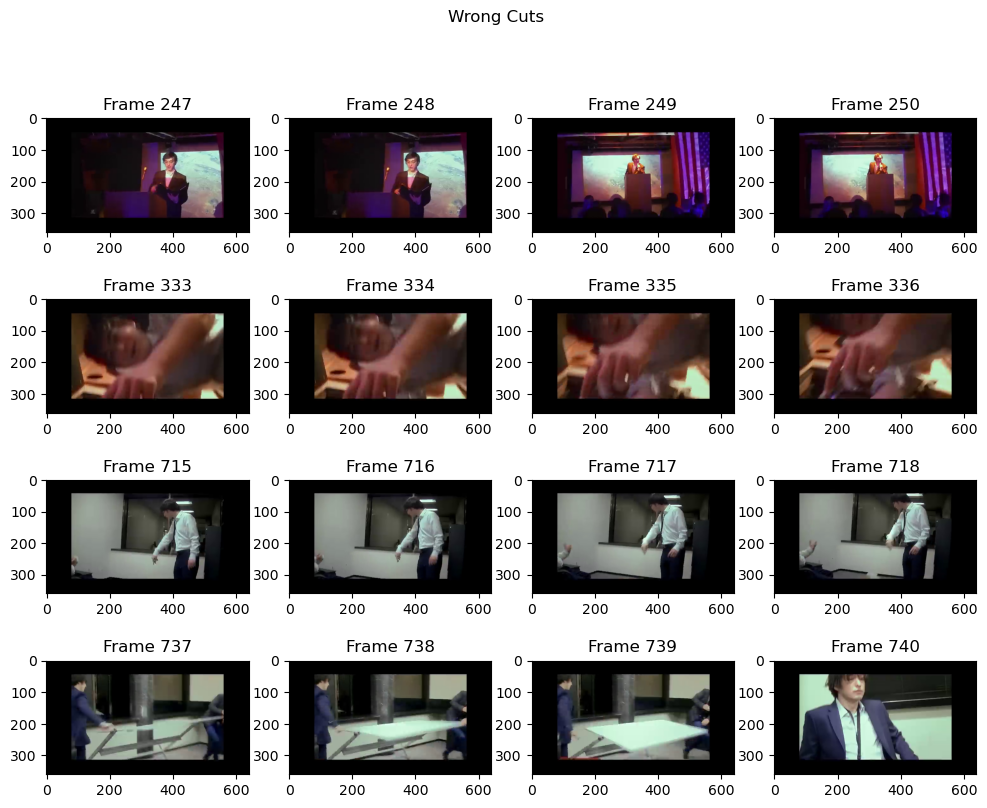

In [128]:
wrong_cuts = df_frame_info[(df_frame_info['real cut'] == False)&(df_frame_info['predicted cut'] == True)].index.values
try:
    chosen_wrong_cuts = np.sort(np.random.choice(wrong_cuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Cuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_cuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
except ValueError:
    if len(wrong_cuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_cuts)}, so there is nothing to draw.')
    elif len(wrong_cuts) == 1:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')
        
        
        for k in range(4):
            idx = chosen_wrong_cuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_cuts = np.sort(wrong_cuts)
        fig, axs = plt.subplots(len(chosen_wrong_cuts), 4)

        fig.set_figheight(2*len(chosen_wrong_cuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Cuts')

        for i in range(len(chosen_wrong_cuts)):
            for k in range(4):
                idx = chosen_wrong_cuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

/tmp/ipykernel_42746/519586235.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


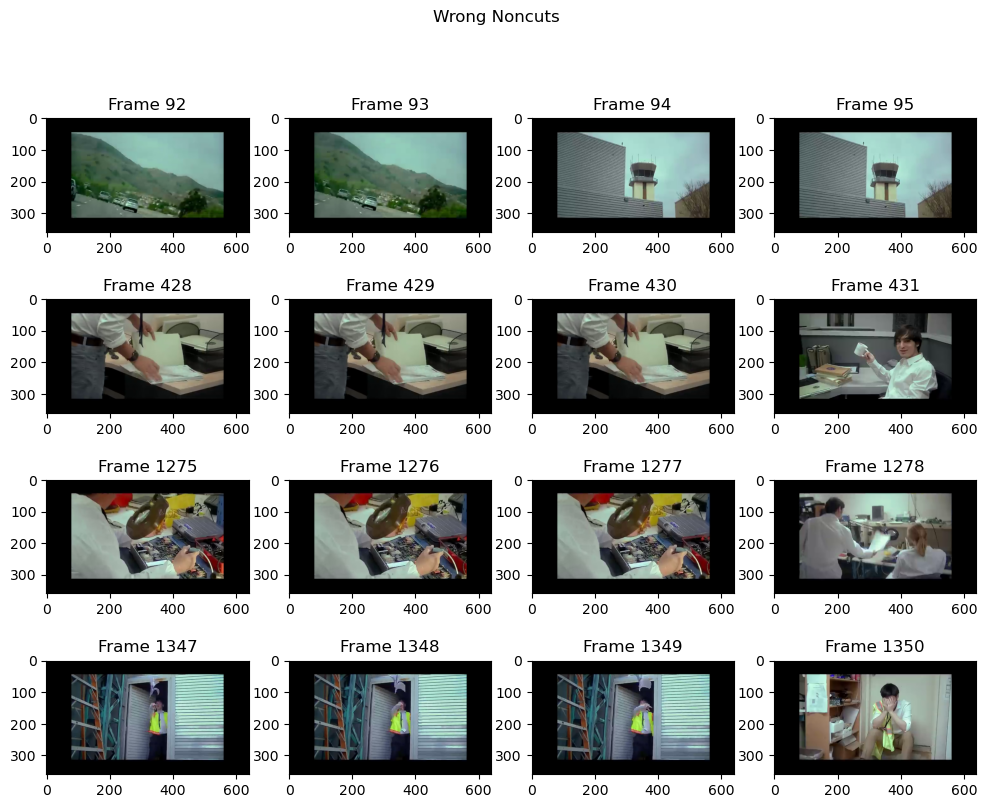

In [129]:
wrong_noncuts = df_frame_info[(df_frame_info['real cut'] == True)&(df_frame_info['predicted cut'] == False)].index.values

try:
    chosen_wrong_noncuts = np.sort(np.random.choice(wrong_noncuts, 4, replace=False))

    fig, axs = plt.subplots(4, 4)

    fig.set_figheight(9)
    fig.set_figwidth(12)
    fig.suptitle('Wrong Noncuts')

    for i in range(4):
        for k in range(4):
            idx = chosen_wrong_noncuts[i] - 2 + k
            frame = video.get_frame(idx)
            axs[i, k].set_title(f'Frame {idx}')
            axs[i, k].imshow(frame)
    fig.show()
    
except ValueError:
    if len(wrong_noncuts) == 0:
        print(f'The number of wrong cuts is {len(wrong_noncuts)}, so there is nothing to draw.')
    elif len(wrong_noncuts) == 1:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(3)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')
        
        
        for k in range(4):
            idx = chosen_wrong_noncuts[0] - 2 + k
            frame = video.get_frame(idx)
            axs[k].set_title(f'Frame {idx}')
            axs[k].imshow(frame)
        
    else:
        chosen_wrong_noncuts = np.sort(wrong_noncuts)
        fig, axs = plt.subplots(len(chosen_wrong_noncuts), 4)

        fig.set_figheight(2*len(chosen_wrong_noncuts) + 1)
        fig.set_figwidth(12)
        fig.suptitle('Wrong Noncuts')

        for i in range(len(chosen_wrong_noncuts)):
            for k in range(4):
                idx = chosen_wrong_noncuts[i] - 2 + k
                frame = video.get_frame(idx)
                axs[i, k].set_title(f'Frame {idx}')
                axs[i, k].imshow(frame)
        fig.show()

In [130]:
dfs_frames.append(df_frame_info.copy())
dfs_square.append(df_square.copy())

# Conclusion

In [131]:
import seaborn as sns
sns.set_theme()

In [132]:
path_trainset = os.path.join('trainsets', model_path[model_path.rfind('/')+1:model_path.rfind('.')] + '.npy')
sets = {'Total': np.arange(11), 
        'Train' : np.load(path_trainset)}
sets.update({'Test': np.setdiff1d(sets['Total'], sets['Train'])})

dfs_square_set = {}
sets

{'Total': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'Train': array([0, 1, 4, 5, 7, 9]),
 'Test': array([ 2,  3,  6,  8, 10])}

In [133]:
fig, axs = plt.subplots(len(sets), 2)
fig.set_figwidth(10)
fig.set_figheight(4.2*len(sets))


for i in range(len(sets)):
    key = list(sets.keys())[i]
    axs[i, 0].set_title(f'{key} COUNT', fontweight="bold")
    axs[i, 1].set_title(f'{key} PORTION', fontweight="bold")
    df_square_i = pd.DataFrame(np.zeros([2, 2], dtype=int), columns=dfs_square[0].columns, index=dfs_square[0].index)
    for k in sets[key]:
        df_square_i = df_square_i + dfs_square[k]
    dfs_square_set.update({key: df_square_i.copy()})
    sns.heatmap(df_square_i, vmin=0, vmax=df_square_i.values.sum(), square=False,
                annot=True, cbar=False, cmap='cividis', fmt="d", linewidths=.5, ax=axs[i, 0])
    df_square_i = df_square_i/df_square_i.values.sum()
    sns.heatmap(df_square_i, vmin=0, vmax=1, square=False,
                annot=True, cbar=False, cmap='cividis', fmt=".4f", linewidths=.5, ax=axs[i, 1])
    axs[i, 0].xaxis.tick_top()
    axs[i, 1].xaxis.tick_top()

In [134]:
clip_names = ['Rammstein - Du Hast', 
              'Rammstein - Rosenrot', 
              'Rammstein - Sonne', 
              'Замай - Одинокое Пламя', 
              'SKRILLEX - Bangarang feat. Sirah', 
              'IC3PEAK - Плак-Плак', 
              'Crystal Castles - Celestica', 
              'Grimes - Oblivion', 
              'Lana Del Rey - Born To Die', 
              'Rihanna - Diamonds', 
              'Joji - Gimme Love']
df_left = pd.DataFrame({'Name' : clip_names, 
                        'Train' : np.isin(np.arange(len(clip_names)), sets['Train'])})

In [135]:
df_conclusion = pd.DataFrame(np.array(dfs_square).reshape([len(dfs_square), 4]), columns=['True Negative', 'False Positive', 'False Negative', 'True Positive'])
df_conclusion = df_conclusion[['True Negative', 'True Positive', 'False Positive', 'False Negative']]

In [136]:
df = pd.concat([df_left, df_conclusion], axis=1)
df.insert(2, 'Precision', df['True Positive']/(df['True Positive'] + df['False Positive']))
df = df.sort_values(by='Precision', ascending=False)
training_index = df[df['Train']].index.values
badposit_index = df[0.33*df['True Positive'] <= df['False Positive'] + df['False Negative']].index.values
training_style = pd.Series('background-color : lightblue', index=training_index)
badposit_style = pd.Series("font-weight: bold; color: darkred", index=badposit_index)
df.style.apply(lambda s: training_style).apply(lambda s: badposit_style) 

In [137]:
df = pd.concat([df_left, (df_conclusion.transpose() / df_conclusion.transpose().sum()).transpose()], axis=1)
df.insert(2, 'Precision', df['True Positive']/(df['True Positive'] + df['False Positive']))
df = df.sort_values(by='Precision', ascending=False)
training_index = df[df['Train']].index.values
badposit_index = df[0.33*df['True Positive'] <= df['False Positive'] + df['False Negative']].index.values
training_style = pd.Series('background-color : lightblue', index=training_index)
badposit_style = pd.Series("font-weight: bold; color: darkred", index=badposit_index)
df.style.apply(lambda s: training_style).apply(lambda s: badposit_style) 

# All Models Metrics

In [138]:
try:
    df_metrics = pd.read_csv('metrics.csv')
except FileNotFoundError:
    df_metrics = pd.DataFrame(columns=['model path', 
                                       'Total Accuracy', 'Total Precision', 'Total Recall', 
                                       'Train Accuracy', 'Train Precision', 'Train Recall', 
                                       'Test Accuracy', 'Test Precision', 'Test Recall'])
df_metrics = df_metrics[df_metrics['model path'] != model_path]

__Reminder:__

$$
    Accuracy = \cfrac{TP + TN}{TP + TN + FP + FN}
$$

$$
    Precision = \cfrac{TP}{TP + FP}
$$

$$
    Recall = \cfrac{TP}{TP + FN}
$$

In [139]:
metric_vals = {}
for key in dfs_square_set:
    df_i = dfs_square_set[key]
    TP = df_i.loc['real cut', 'predicted cut']
    TN = df_i.loc['real noncut', 'predicted noncut']
    FP = df_i.loc['real noncut', 'predicted cut']
    FN = df_i.loc['real cut', 'predicted noncut']
    metric_vals.update({key : {'Accuracy' : (TP + TN)/(TP + TN + FP + FN), 
                               'Precision' : TP / (TP + FP), 
                               'Recall' : TP / (TP + FN)}})
pd.DataFrame(metric_vals)

Total     Train      Test
Accuracy   0.992224  0.992564  0.991798
Precision  0.765752  0.783019  0.740648
Recall     0.983681  0.994553  0.967427

In [140]:
row = {'model path' : model_path}
for key0 in metric_vals:
    for key1 in metric_vals[key0]:
        key2 = key0 + ' ' + key1
        row.update({key2 : metric_vals[key0][key1]})
row = pd.DataFrame([row])

In [141]:
df_metrics = pd.concat([df_metrics, row], ignore_index=True)
df_metrics = df_metrics.drop_duplicates()
df_metrics = df_metrics.sort_values(by='model path')
df_metrics.to_csv('metrics.csv', index=False)

df_index = df_metrics[df_metrics['model path'] == model_path].index.values
df_style = pd.Series('background-color : yellow', index=df_index)
df_metrics.style.apply(lambda s: df_style)